# SBERT Classfication using the sentance-transform library

The preprocessed dataset is loaded in using pandas library

In [3]:
import pandas as pd
#read the dataset, and name the columns     
df = pd.read_csv('questions_data_clean_stopword_lemma_v4.csv', header=0)


#display the structure of the dataframe
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23873 entries, 0 to 23872
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Title                      23873 non-null  object
 1   Description                23873 non-null  object
 2   Creation Time              23873 non-null  object
 3   Link                       23873 non-null  object
 4   Clean_Text_Init            23873 non-null  object
 5   Clean_Text_Stopword        23873 non-null  object
 6   Clean_Text_Stopword_Lemma  23873 non-null  object
dtypes: object(7)
memory usage: 1.3+ MB
None


The three options of processed text content are the columns: Clean_Text_Init, Clean_Text_Stopword, Clean_Text_Stopword_Lemma.

For SBERT, it is recommend to to remove stopwords or lemmatise the text as it may change the way the transformer understands the text.

Therefore, the column Clean_Text_Init, will be used as the input to the pretrained transformer.

This is text that is cleaned by making it all lowercase, and removing code blocks, symbols, screenshots, and links. But without stopword removal or lemmatisation.

In [4]:
#sbert embedding method used with DBSCAN clustering
from sentence_transformers import SentenceTransformer
docs =df['Clean_Text_Init']
#use the pretrained model available on huggingface
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
embeddings = model.encode(docs)

In [5]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

total_points = embeddings.shape[0]

#iteratively try different eps values to compare clusters
for i in range(1,20):
    #using the cosine similarity metric and 20 samples is required to make sure clusters are large enough
    dbscan = DBSCAN(eps=0.1+0.01*i, min_samples=20, metric='cosine')
    cluster_labels = dbscan.fit_predict(embeddings)
    
    num_noise = np.sum(cluster_labels == -1)
    num_assigned = total_points - num_noise
    number_of_clusters = len(set(cluster_labels))-1

    filtered_embeddings = embeddings[cluster_labels != -1]
    filtered_labels = cluster_labels[cluster_labels != -1]
    unique_clusters = np.unique(filtered_labels)

    silhouette = round(silhouette_score(filtered_embeddings, filtered_labels, metric='cosine'),2) if len(filtered_labels)!=0 else 0

    print(f"For EPS value: {round(0.1+0.01*i,2)}, They are {number_of_clusters} clusters, with {num_assigned} posts assigned. Silhouette Score: {silhouette:.2f}")

For EPS value: 0.11, They are 0 clusters, with 0 posts assigned. Silhouette Score: 0.00
For EPS value: 0.12, They are 0 clusters, with 0 posts assigned. Silhouette Score: 0.00
For EPS value: 0.13, They are 0 clusters, with 0 posts assigned. Silhouette Score: 0.00
For EPS value: 0.14, They are 0 clusters, with 0 posts assigned. Silhouette Score: 0.00
For EPS value: 0.15, They are 0 clusters, with 0 posts assigned. Silhouette Score: 0.00
For EPS value: 0.16, They are 0 clusters, with 0 posts assigned. Silhouette Score: 0.00
For EPS value: 0.17, They are 0 clusters, with 0 posts assigned. Silhouette Score: 0.00
For EPS value: 0.18, They are 2 clusters, with 61 posts assigned. Silhouette Score: 0.69
For EPS value: 0.19, They are 2 clusters, with 88 posts assigned. Silhouette Score: 0.67
For EPS value: 0.2, They are 5 clusters, with 187 posts assigned. Silhouette Score: 0.48
For EPS value: 0.21, They are 5 clusters, with 299 posts assigned. Silhouette Score: 0.43
For EPS value: 0.22, They a

To choose the best dbscan paramters, the assignment requirements need to be considered.

There needs to be at least 100 posts assigned, with a miniumum of 10 posts per category. 

Additionally, a Silhouette score of between 0.5-0.75 is considered decently distinct clustering

Therefore the best dbscan parameters are EPS value: 0.22, with 5 clusters having 425 posts assigned. Silhouette Score: 0.49.

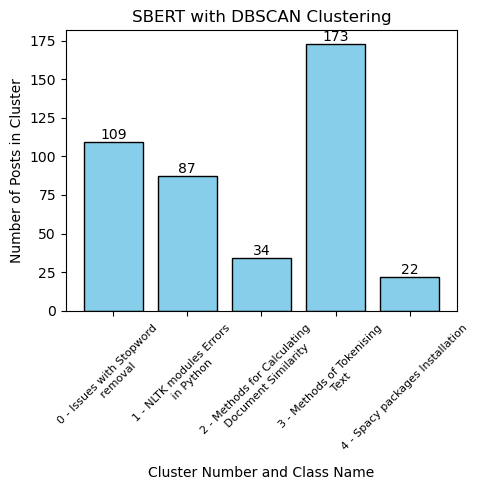

In [84]:
from sklearn.cluster import DBSCAN

#run the final sbert clustering
clustering = DBSCAN(eps=0.22, min_samples=20, metric='cosine').fit(embeddings)
cluster_labels = clustering.labels_

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter 

clusters=[]
for i in cluster_labels:
    clusters.append(i)

unique_clusters, counts = np.unique(clusters, return_counts=True)
#remove the -1 cluster (unassigned posts)
unique_clusters=unique_clusters[1:] 
#after looking at each post in the cluster, human evaluation was used to create the class names
classes={0:'0 - Issues with Stopword removal', 1: '1 - NLTK modules Errors in Python', 2: '2 - Methods for Calculating Document Similarity',
        3: '3 - Methods of Tokenising Text', 4: '4 - Spacy packages Installation'}
class_names=[classes[cluster] for cluster in unique_clusters]


plt.figure(figsize=(5, 5))
bars = plt.bar(class_names, counts[1:], align='center', color='skyblue', edgecolor='black')
plt.bar_label(bars)
plt.xticks([0,1,2,3,4], [' '.join(cluster.split()[:5] + ['\n'] + cluster.split()[5:]) for cluster in class_names],fontsize=8,rotation=45)
plt.xlabel("Cluster Number and Class Name")
plt.ylabel("Number of Posts in Cluster")
plt.title("SBERT with DBSCAN Clustering")
plt.tight_layout()
plt.show()

Plot the evolution of each cluster over time using a time series graph.

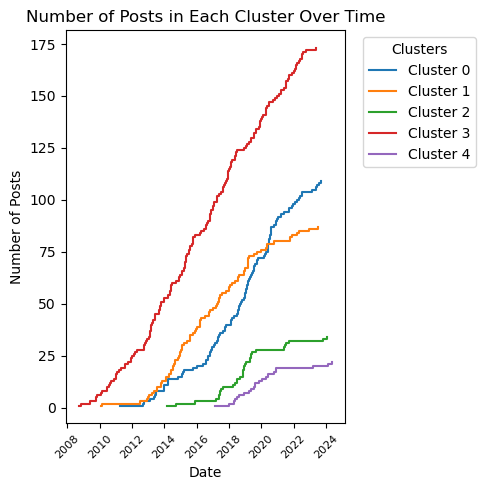

In [96]:
#convert creation time column to pandas datetime type
df['Creation Time'] = pd.to_datetime(df['Creation Time'], format='mixed')
df_sorted=df.sort_values('Creation Time')

plt.figure(figsize=(5, 5))
#for each cluster, create a time series line
for cluster_id in sorted(df_sorted['ClusterID'].unique()):
    if cluster_id!=-1:
        cluster_data = df_sorted[df_sorted['ClusterID'] == cluster_id]
        
        dates = cluster_data['Creation Time']
        counts = range(1, len(cluster_data) + 1)
        #plot each post in the cluster as a timestep
        plt.step(dates, counts, where='post', label=f'Cluster {cluster_id}')

plt.title('Number of Posts in Each Cluster Over Time')
plt.xlabel('Date')
plt.xticks(rotation=45, fontsize=8)
plt.ylabel('Number of Posts')
plt.legend(title='Clusters', loc='upper left', bbox_to_anchor=(1.04, 1))
plt.tight_layout()
plt.show()


Checking the silhouette score, using SKLearn module, the model has a score of 0.49, which indicates the model is just considered decently clustered, as it is close to 0.5-0.75 score rating.

In [10]:
from sklearn.metrics import silhouette_score

#remove embeddings of that were not clustered (label=-1)
filtered_embeddings = embeddings[cluster_labels != -1]
filtered_labels = cluster_labels[cluster_labels != -1]

unique_clusters = np.unique(filtered_labels)

silhouette = silhouette_score(filtered_embeddings, filtered_labels, metric='cosine')

print(round(silhouette,2))

0.49


Map each cluster with the some of the original data for analysis and displaying in a HTML table

In [95]:
clusters = {0:[],1:[],2:[],3:[],4:[]}

df['ClusterID'] = [-1] * len(df)
unique_labels = np.unique(cluster_labels)
for label in sorted(unique_labels):
    indices = np.where(cluster_labels == label)[0]
    num_in_cluster = len(indices)
    example_indices = indices[:]
    for i in example_indices:
        if label!=-1:
            clusters[label].append([df.at[i,'Title'],df.at[i,'Link'],df.at[i,'Clean_Text_Stopword_Lemma']])
        df.at[i, 'ClusterID'] = label

cluster_freq = {0:[],1:[],2:[],3:[],4:[]}
for class_no, items in sorted(clusters.items()):
    word_freq = {}
    
    post_index = 0
    for post in items:
        words = post[2].split()
        
        #count the commonwords
        for word in words:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
        
        post_index += 1
    
    top_10 = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    top_10_words='-'.join([words for words,count in top_10][:10])
    cluster_freq[class_no].append(top_10_words)



AttributeError: 'dict' object has no attribute 'head'

Create HTML table for viewing random 10 posts from each cluster

In [94]:
import html
import random
random.seed(123)

data = clusters
#HTML table structure with CSS for basic styling
html_output = """
<style>
  table {
    border-collapse: collapse;
    width: 100%;
    font-family: sans-serif;
  }
  th, td {
    border: 1px solid #ddd;
    padding: 8px;
    text-align: left;
    vertical-align: top;
  }
  th {
    background-color: #f2f2f2;
  }
  tr:nth-child(even) {
    background-color: #f9f9f9;
  }
  td[rowspan] {
    font-weight: bold;
    vertical-align: top; 
    text-align: center;
    width:5%;
  }
  a {
    color: #0066cc;
    text-decoration: none;
  }
  a:hover {
    text-decoration: underline;
  }
</style>
<table>
  <thead>
    <tr>
      <th>Cluster</th>
      <th>Top 10 Words</th>
      <th>Post Title</th>
      <th>URL</th>
    </tr>
  </thead>
  <tbody>
"""
#start table
for class_no, items in sorted(data.items()):
    sample_size = min(10, len(items)) #max 10 samples

    if sample_size > 0:
        sample = random.sample(items, sample_size) #random 10 examples
    else:
        sample = []

    rows= len(sample)
    
    for i, item in enumerate(sample):
        title = item[0] if len(item) > 0 else "N/A"
        url = item[1] if len(item) > 1 else "#"
        escaped_title = html.escape(title)
        escaped_url = html.escape(url)

        html_output += "<tr>"
        if i == 0:
            html_output += f'<td rowspan="{rows}">{class_no}</td>'
            html_output += f'<td rowspan="{rows}">{cluster_freq[class_no][0]}</td>'
        html_output += f'<td>{escaped_title}</td>'
        html_output += f'<td><a href="{escaped_url}" target="_blank">{escaped_url}</a></td>'
        html_output += "</tr>\n"

html_output += """
  </tbody>
</table>
"""

with open('data_table_sampled.html', 'w', encoding='utf-8') as f:
    f.write(html_output)